# Augmented Reality App

# Imports

In [77]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

# Load Marker and Source images

Marker reference image:

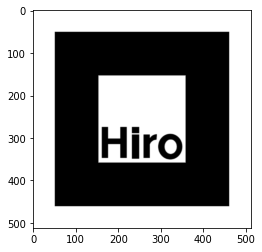

In [78]:
reference_image = cv2.imread('../img/hiro.png', 0)

plt.imshow(reference_image, cmap='gray')
plt.show()

Source image that contains the marker:

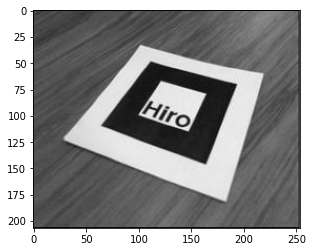

In [79]:
image = cv2.imread('../img/sourceImg_hiro.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.show()

Images are converted to gray scale for better processing.

# Square detection

Convert the image to grayscale

In [80]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Apply GaussianBlur to reduce noise and help Canny edge detection

In [81]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

Apply Canny edge detection

In [82]:
edges = cv2.Canny(blurred, 50, 150)

"Number of edges detected:", len(edges)

('Number of edges detected:', 207)

Plot edges

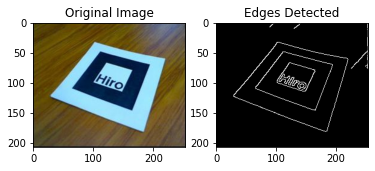

In [83]:
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edges Detected')
plt.show()

Find lines using HoughLinesP

In [84]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

"Number of lines found:", len(lines)

('Number of lines found:', 9)

Plot the lines

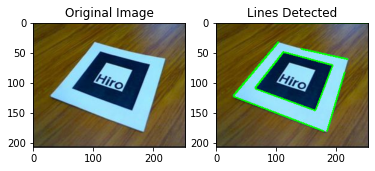

In [85]:
line_image = np.copy(image)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)), plt.title('Lines Detected')
plt.show()

Find intersections of lines

In [86]:
def find_intersections(lines, image_shape):
    intersections = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            x1, y1, x2, y2 = lines[i][0]
            x3, y3, x4, y4 = lines[j][0]

            # Check if the lines are not too parallel
            angle_threshold = np.radians(10)
            if np.abs(np.arctan2(y2 - y1, x2 - x1) - np.arctan2(y4 - y3, x4 - x3)) > angle_threshold:
                # Calculate intersection point
                det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
                if det != 0:  # Check if lines are not parallel
                    intersection_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
                    intersection_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det
                    
                    # Check if the intersection point is within the image bounds
                    if 0 <= intersection_x < image_shape[1] and 0 <= intersection_y < image_shape[0]:
                        intersections.append((int(intersection_x), int(intersection_y)))

    return intersections


In [104]:
intersections = find_intersections(lines, image.shape)

"Number of intersections found:", len(intersections)

('Number of intersections found:', 20)

Plot the intersections

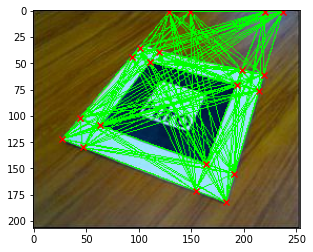

In [105]:
# Plot the original image with intersections
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot intersections
if intersections:
    intersections_array = np.array(intersections)
    plt.scatter(intersections_array[:, 0], intersections_array[:, 1], c='red', marker='x')

plt.show()

Find liness based on intersections

In [89]:
squares = []

for i in range(len(intersections)):
        for j in range(i+1, len(intersections)):
            for k in range(j+1, len(intersections)):
                for l in range(k+1, len(intersections)):
                    square = np.array([intersections[i], intersections[j], intersections[k], intersections[l]])
                    squares.append(square)

"Number of squares found:", len(squares)

('Number of squares found:', 4845)

In [118]:
def find_duplicate_squares(intersections):
    squares = []
    duplicate_squares = []
    centers = []
    for i in range(len(intersections)):
        for j in range(i+1, len(intersections)):
            for k in range(j+1, len(intersections)):
                for l in range(k+1, len(intersections)):
                    square = np.array([intersections[i], intersections[j], intersections[k], intersections[l]])
                    center = np.mean(square, axis=0)  # Calculate the center of the square
                    
                    sqr_index = 0
                    for prev_center in centers:
                        if np.allclose(center, prev_center):
                            duplicate_sqr = squares[sqr_index]
                            # Duplicate center!
                            duplicate_squares.append(square)
                            duplicate_squares.append(duplicate_sqr)
                            break
                        sqr_index += 1

                    squares.append(square)
                    centers.append(center)

    return squares

In [123]:
import numpy as np

def are_lines_parallel(line1, line2, angle_threshold=np.radians(10)):
    # Check if two lines are parallel based on their angles
    print(line1, line2)
    angle1 = np.arctan2(line1[3] - line1[1], line1[2] - line1[0])
    angle2 = np.arctan2(line2[3] - line2[1], line2[2] - line2[0])

    return np.abs(angle1 - angle2) < angle_threshold

def find_duplicate_squares(intersections):
    squares = []
    duplicate_squares = []
    centers = []

    for i in range(len(intersections)):
        for j in range(i+1, len(intersections)):
            for k in range(j+1, len(intersections)):
                for l in range(k+1, len(intersections)):
                    square = np.array([intersections[i], intersections[j], intersections[k], intersections[l]])
                    center = np.mean(square, axis=0)  # Calculate the center of the square

                    lines = [
                        square[0] + square[1],
                        square[0] + square[2],
                        square[0] + square[3],
                        square[1] + square[2],
                        square[1] + square[3],
                        square[2] + square[3],
                    ]

                    is_parallel = []
                    for index1 in range(6): # square has 6 unique lines
                        for index2 in range(index1, 6):  # check lines uniquely without repeating
                            is_parallel.append(are_lines_parallel(lines[index1], lines[index2]))
                            # Use this in the next block


                    # Check for parallelism between pairs of lines in the square
                    lines_parallel = (
                        are_lines_parallel(lines[0], lines[1]) and are_lines_parallel(lines[2], lines[3]) or
                        are_lines_parallel(lines[0], lines[2]) and are_lines_parallel(lines[1], lines[3]) or
                        are_lines_parallel(lines[0], lines[3]) and are_lines_parallel(lines[1], lines[2])
                    )

                    if lines_parallel:
                        # Check if a square with the same center already exists
                        duplicate = False
                        for prev_center, prev_square in zip(centers, squares):
                            if np.allclose(center, prev_center):
                                duplicate_sqr = prev_square
                                # Duplicate center!
                                duplicate_squares.append(square)
                                duplicate_squares.append(duplicate_sqr)
                                duplicate = True
                                break

                        if not duplicate:
                            squares.append(square)
                            centers.append(center)

    return squares, duplicate_squares

squares = find_duplicate_squares(intersections)
len(squares)

[[129   1]
 [237   1]
 [149   1]
 [220   1]]
[129   1] [237   1]


IndexError: index 3 is out of bounds for axis 0 with size 2

In [119]:
squares = find_duplicate_squares(intersections)

In [120]:
len(squares)

4845

In [90]:
# Draw the detected squares on the original image
for square in squares:
    cv2.polylines(image, [square], isClosed=True, color=(0, 255, 0), thickness=1)

# Display the result
cv2.imshow('Square Detector', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Plot detected squares along with intersections

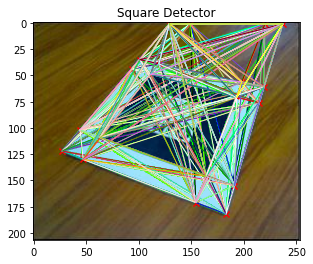

In [91]:
# Plot the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Get all possible color names from matplotlib
colors = list(plt.cm.colors.cnames.keys())

# Plot squares
if squares:
    i = 0
    for square in squares:
        square = np.array(square)
        plt.plot(np.append(square[:, 0], square[0, 0]), np.append(square[:, 1], square[0, 1]), c=colors[i], linewidth=1)
        i+=1
        if i >= len(colors): break

# Plot intersections
plt.scatter(intersections[:, 0], intersections[:, 1], c='red', marker='x')

# Display the plot
plt.title('Square Detector')
plt.show()